## Fibonacci-Based Neural Network Topology

### Concept
The **Fibonacci sequence** is a well-known numerical sequence where each term is the sum of the two preceding ones:

$$
F_0 = 0, \quad F_1 = 1, \quad F_n = F_{n-1} + F_{n-2} \quad \text{for } n \ge 2
$$

This sequence appears in natural phenomena (e.g., phyllotaxis in plants, spiral shells, branching structures) and has inspired computational models due to its **scale-invariant growth** and **self-similar structure**.

In this project, we leverage Fibonacci numbers to define **graph connectivity**:
- Each node represents a term in the Fibonacci sequence.
- Each new node connects to **its two immediate predecessors** in the sequence.
- This forms a **non-uniform, hierarchically connected network** that can be used as:
  - A **neural network architecture template** with irregular layer sizes.
  - A **graph-structured dataset** for message-passing neural networks (MPNNs).
  - A **biologically inspired topology** for information propagation.

---

### Code Explanation
1. **Graph Initialization**  
   We start with two nodes ($0$ and $1$) connected by an edge.

2. **Fibonacci Node Generation**  
   For each subsequent step, we:
   - Compute the next Fibonacci number.
   - Add it as a new node to the graph.
   - Connect it to the previous two Fibonacci numbers in the sequence.

3. **Network Visualization**  
   The `networkx` and `matplotlib` libraries are used to:
   - Display the graph structure.
   - Show how connections grow following Fibonacci rules.

---

### Example Output (Depth = 15)
For a depth of $15$:
- The node labels correspond to Fibonacci numbers up to $F_{14}$.
- The graph shows **clustered hubs** (small numbers appear often as predecessors).
- Connections naturally form **shortcuts** that can reduce path length, potentially affecting signal propagation efficiency.

---

**Applications in AI**:
- **Custom RNN/Graph Neural Network architectures** inspired by natural growth patterns.
- **Sparse connectivity models** that reduce computational complexity.
- **Biologically motivated design** for neuromorphic computing.

> **Note:** This is a *topology generator*, not yet a trained neural network. To use it in deep learning, map nodes to neurons and edges to synaptic weights.


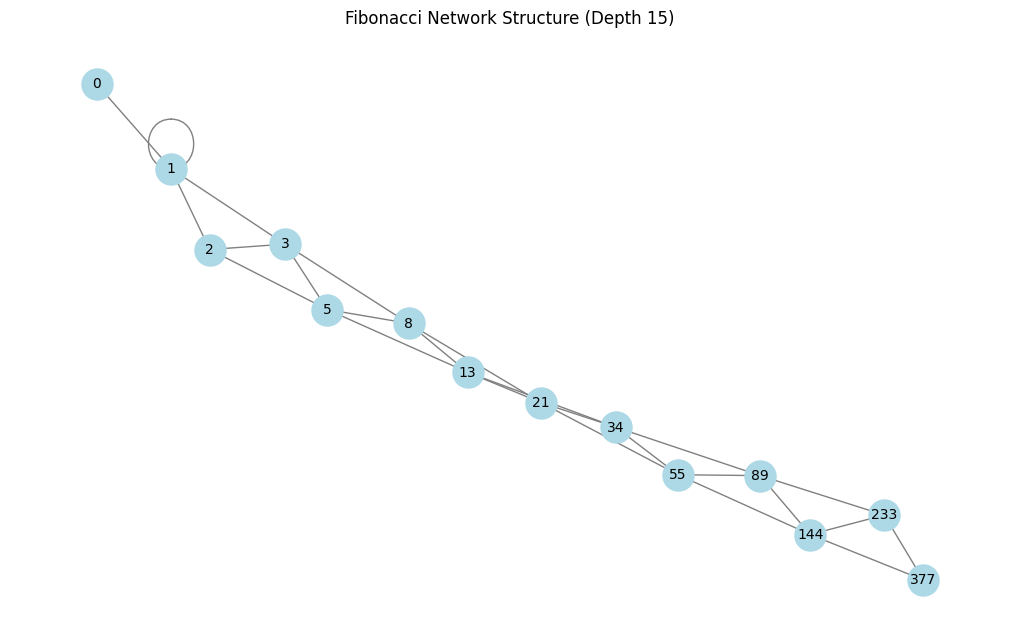

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def fibonacci_network(n):
    """
    Constructs an undirected graph G = (V, E) where the vertex set V corresponds to Fibonacci numbers,
    and edges E connect each newly introduced node to its two immediate predecessors in the sequence.

    Parameters:
    -----------
    n : int
        The number of Fibonacci terms to be included as nodes in the network.

    Returns:
    --------
    G : networkx.Graph
        An undirected graph representing the Fibonacci connectivity pattern.
    """
    G = nx.Graph()

    # Initialization: insert the first two nodes corresponding to F_0 = 0 and F_1 = 1
    G.add_node(0)
    G.add_node(1)
    G.add_edge(0, 1)

    # Initialize the sequence list with the first two Fibonacci numbers
    fib_sequence = [0, 1]

    # Iteratively construct the graph for the next n - 2 Fibonacci numbers
    for i in range(2, n):
        # Compute the next Fibonacci number
        new_node = fib_sequence[-1] + fib_sequence[-2]
        fib_sequence.append(new_node)
        G.add_node(new_node)

        # Establish edges linking the new node to its two immediate predecessors
        G.add_edge(new_node, fib_sequence[-2])
        G.add_edge(new_node, fib_sequence[-3])

    return G

# Generate the Fibonacci network with controlled depth to manage computational complexity
fib_depth = 15  # Controls the number of Fibonacci nodes included
G = fibonacci_network(fib_depth)

# Visualize the constructed network topology
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title(f"Fibonacci Network Structure (Depth {fib_depth})")
plt.show()


### Imports and Dependencies

We begin by importing necessary libraries:

- **PyTorch** for defining the neural network and training.
- **Torchvision** for loading the FashionMNIST dataset.
- **NetworkX** and **Matplotlib** for graph construction and visualization.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt


### Fibonacci Network Construction

This function builds an undirected graph where nodes correspond to Fibonacci numbers.  
Edges connect each new node to its two immediate predecessors, reflecting the recursive structure of the Fibonacci sequence.

This graph topology serves as the architectural template for the neural network connectivity.


In [6]:
def fibonacci_network(n):
    G = nx.Graph()
    G.add_node(0)
    G.add_node(1)
    G.add_edge(0, 1)

    fib_sequence = [0, 1]
    for i in range(2, n):
        new_node = fib_sequence[-1] + fib_sequence[-2]
        fib_sequence.append(new_node)
        G.add_node(new_node)
        G.add_edge(new_node, fib_sequence[-2])
        G.add_edge(new_node, fib_sequence[-3])

    return G


### Fibonacci Neural Network Architecture

- The graph nodes define the number of neurons in the hidden layer.
- Adjacency is encoded as a tensor to model connectivity.
- Weights on edges are learnable parameters.
- Forward propagation consists of:
  1. Linear input layer transforming raw input to hidden node activations.
  2. Graph-weighted propagation using the adjacency and weights matrices.
  3. Nonlinear ReLU activation.
  4. Output linear layer mapping hidden states to class logits.


In [7]:
class FibonacciNN(nn.Module):
    def __init__(self, fib_graph, input_size, output_size):
        super(FibonacciNN, self).__init__()

        self.nodes = list(fib_graph.nodes)
        self.num_nodes = len(self.nodes)
        self.node_index = {node: i for i, node in enumerate(self.nodes)}

        self.adjacency = torch.zeros((self.num_nodes, self.num_nodes))
        for node1, node2 in fib_graph.edges:
            if node1 in self.node_index and node2 in self.node_index:
                i, j = self.node_index[node1], self.node_index[node2]
                self.adjacency[i, j] = 1.0
                self.adjacency[j, i] = 1.0

        self.weights = nn.Parameter(torch.randn(self.num_nodes, self.num_nodes) * 0.1)
        self.input_layer = nn.Linear(input_size, self.num_nodes)
        self.output_layer = nn.Linear(self.num_nodes, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        x = torch.matmul(self.adjacency * self.weights, x.T).T
        x = torch.relu(x)
        x = self.output_layer(x)
        return x


### Dataset Preparation

We use the FashionMNIST dataset as a benchmark for classification.

- Images are normalized and converted to tensors.
- A DataLoader batches and shuffles the data for training.


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:00<00:00, 28.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.04MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 15.8MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.84MB/s]


### Model and Training Setup

- Construct the Fibonacci graph with specified depth.
- Instantiate the Fibonacci neural network.
- Define the cross-entropy loss for multi-class classification.
- Use the Adam optimizer for parameter updates.


In [9]:
fib_depth = 15
G = fibonacci_network(fib_depth)

input_size = 28 * 28
output_size = 10

model = FibonacciNN(G, input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Accuracy Computation

Evaluate model performance on a given DataLoader by calculating the proportion of correctly classified samples.


In [10]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28 * 28)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


### Model Training

Train the Fibonacci neural network for 10 epochs, tracking:

- Average training loss per epoch.
- Training accuracy per epoch.
- Print progress after each epoch.


In [11]:
num_epochs = 10
loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.view(-1, 28 * 28)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    accuracy = compute_accuracy(model, train_loader)
    accuracy_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 0.7581, Accuracy: 0.8078
Epoch [2/10], Loss: 0.4826, Accuracy: 0.8418
Epoch [3/10], Loss: 0.4421, Accuracy: 0.8470
Epoch [4/10], Loss: 0.4197, Accuracy: 0.8593
Epoch [5/10], Loss: 0.4077, Accuracy: 0.8566
Epoch [6/10], Loss: 0.3965, Accuracy: 0.8613
Epoch [7/10], Loss: 0.3882, Accuracy: 0.8652
Epoch [8/10], Loss: 0.3807, Accuracy: 0.8649
Epoch [9/10], Loss: 0.3776, Accuracy: 0.8714
Epoch [10/10], Loss: 0.3711, Accuracy: 0.8631


### Training Metrics Visualization

Plot loss and accuracy curves over epochs to observe learning trends of the Fibonacci Neural Network.


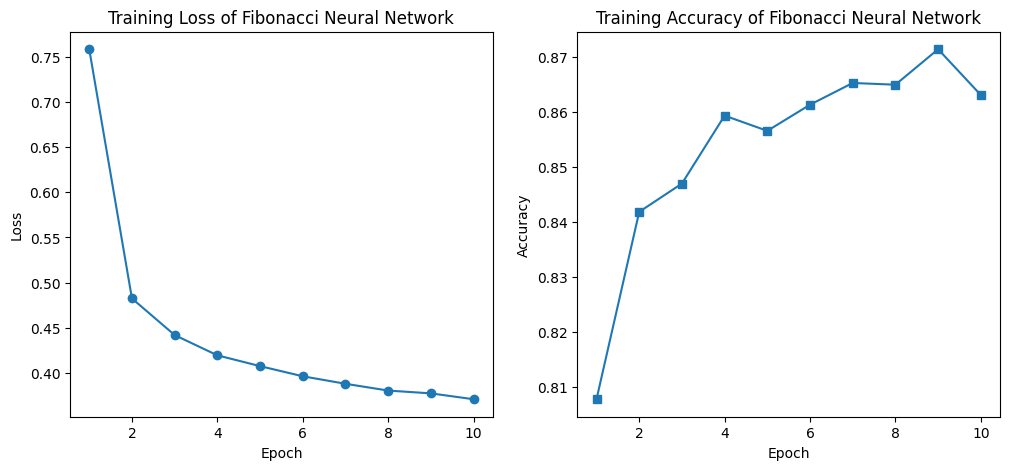

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of Fibonacci Neural Network')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy_history, marker='s', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of Fibonacci Neural Network')

plt.show()


## Analysis of Training Dynamics for the Fibonacci Neural Network

The figure above illustrates the training progression of the Fibonacci Neural Network on the FashionMNIST dataset over 10 epochs, with two key performance metrics tracked:

### 1. Training Loss (Left Panel)

- The **training loss** quantifies the discrepancy between predicted and true labels, as measured by the cross-entropy loss function.
- The graph exhibits a **monotonically decreasing trend**, indicating effective gradient-based optimization and convergence toward a local minimum.
- Initial epochs show rapid loss reduction, reflecting significant parameter updates early in training.
- The later epochs demonstrate diminishing returns in loss improvement, characteristic of typical neural network learning curves.

### 2. Training Accuracy (Right Panel)

- The **training accuracy** shows the proportion of correctly classified samples per epoch.
- The network achieves a high accuracy exceeding **86%** by the final epoch, demonstrating successful learning of discriminative features.
- Minor fluctuations in accuracy across epochs are common due to stochasticity inherent in mini-batch gradient descent.
- The steady increase confirms the network’s capacity to generalize from training data, despite the sparse and irregular Fibonacci-based connectivity.

---

### Pedagogical Remarks

- These plots provide empirical validation that the Fibonacci-inspired architecture supports effective supervised learning, despite its non-standard topology.
- Students should appreciate the **tradeoff between architectural sparsity and learning capacity**, which is evident in the steady but not instantaneous performance gains.
- Further experimentation with hyperparameters, network depth, and graph connectivity can yield insights into optimizing such bio-inspired neural network models.

---

**Recommended Exercises:**

1. Compare training dynamics of the FibonacciNN to a fully connected baseline model.
2. Investigate the effect of varying Fibonacci depth on convergence speed and final accuracy.
3. Analyze loss and accuracy on validation and test datasets to assess generalization.

---

This visualization thus serves as a concrete demonstration of how recursive graph-based architectures can be harnessed for real-world machine learning tasks.
